<a href="https://colab.research.google.com/github/kibeomkim-spec/deep_learning_2023/blob/master/custom_train_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/project
# !git clone https://github.com/ultralytics/yolov5.git

/content/drive/MyDrive/project


In [2]:
%cd /content/drive/MyDrive/project/yolov5/

/content/drive/MyDrive/project/yolov5


In [ ]:
english_words = [
    "Whole House", "Roof", "House Wall", "Door", "Window",
    "Chimney", "Smoke", "Fence", "Road", "Pond",
    "Mountain", "Tree", "Flower", "Grass", "Sun",
    "Whole Tree", "Trunk", "Canopy", "Branch", "Root",
    "Leaves", "Fruit", "Swing", "Bird", "Squirrel",
    "Cloud", "Moon", "Star", "Whole Person", "Head",
    "Face", "Eyes", "Nose", "Mouth", "Ears",
    "Hair", "Neck", "Upper Body", "Arms", "Hands",
    "Legs", "Feet", "Button", "Pocket", "Sneakers",
    "Women's Shoes", "Men's Shoes"]

In [3]:
import yaml
import json
import csv
import os
import cv2
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [ ]:
path = os.path.join(os.getcwd(),'custom_dataset')

with open(os.path.join(os.getcwd(), 'data','data.yaml'), 'r', encoding='utf-8') as f:
  data = yaml.load(f, Loader=yaml.FullLoader)
print(data)

{'names': ['Whole House', 'Roof', 'House Wall', 'Door', 'Window', 'Chimney', 'Smoke', 'Fence', 'Road', 'Pond', 'Mountain', 'Tree', 'Flower', 'Grass', 'Sun', 'Whole Tree', 'Trunk', 'Canopy', 'Branch', 'Root', 'Leaves', 'Fruit', 'Swing', 'Bird', 'Squirrel', 'Cloud', 'Moon', 'Star', 'Whole Person', 'Head', 'Face', 'Eyes', 'Nose', 'Mouth', 'Ears', 'Hair', 'Neck', 'Upper Body', 'Arms', 'Hands', 'Legs', 'Feet', 'Button', 'Pocket', 'Sneakers', "Women's Shoes", "Men's Shoes"], 'nc': 47, 'path': '/content/drive/MyDrive/project/dataset', 'train': '/content/drive/MyDrive/project/dataset/train/images', 'val': '/content/drive/MyDrive/project/dataset/val/images'}


In [ ]:
data['path'] = path
data['train'] = os.path.join('train', 'images')
data['val'] = os.path.join('val', 'images')
data['nc'] = len(english_words)
data['names'] = english_words

with open(os.path.join(os.getcwd(), 'data', 'data.yaml'), 'w', encoding="utf-8") as f:
  yaml.dump(data, f, allow_unicode=True)

print(data)

{'names': ['Whole House', 'Roof', 'House Wall', 'Door', 'Window', 'Chimney', 'Smoke', 'Fence', 'Road', 'Pond', 'Mountain', 'Tree', 'Flower', 'Grass', 'Sun', 'Whole Tree', 'Trunk', 'Canopy', 'Branch', 'Root', 'Leaves', 'Fruit', 'Swing', 'Bird', 'Squirrel', 'Cloud', 'Moon', 'Star', 'Whole Person', 'Head', 'Face', 'Eyes', 'Nose', 'Mouth', 'Ears', 'Hair', 'Neck', 'Upper Body', 'Arms', 'Hands', 'Legs', 'Feet', 'Button', 'Pocket', 'Sneakers', "Women's Shoes", "Men's Shoes"], 'nc': 47, 'path': '/content/drive/MyDrive/project/yolov5/custom_dataset', 'train': 'train/images', 'val': 'val/images'}


In [4]:
gc.collect()
print(torch.cuda.empty_cache())

None


In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [ ]:
entry_number = [0, 15, 28]

def remove_attribute(path):
  new_text_content = ''
  with open(path, 'r') as f:
    lines = f.readlines()
    for i, l in enumerate(lines):
      if int(l.split(' ')[0]) in entry_number:
        new_text_content += l;

  with open(path, "w") as f:
    f.write(new_text_content)

In [ ]:
root = os.path.join(os.getcwd(), 'custom_dataset', 'train', 'labels')
for file in os.listdir(root):
  remove_attribute(os.path.join(root, file))

root = os.path.join(os.getcwd(), 'custom_dataset', 'val', 'labels')
for file in os.listdir(root):
  remove_attribute(os.path.join(root, file))

In [ ]:
img_width = img_height = 1280
print(img_width, img_height)

1280 1280


In [ ]:
def set_centroid(path):
  new_text_content = ''
  with open(path, 'r', encoding="utf-8-sig", errors="ignore") as f:
      csv_reader = csv.reader(f, delimiter=' ')
      for row in csv_reader:
        class_number = row[0]
        x = float(row[1]) * img_width
        y = float(row[2]) * img_height
        bbox_width = float(row[3]) * img_width
        bbox_height = float(row[4]) * img_height
        xcentre = (x + bbox_width / 2) / img_width
        ycentre = (y + bbox_height / 2) / img_height
        new_text_content +=  " ".join([class_number, str(xcentre), str(ycentre), str(bbox_width / img_width), str(bbox_height / img_height)]) + "\n"

  with open(path, "w") as f:
    f.write(new_text_content)

In [ ]:
def draw_bounding_box(path, file_name):
  img_path = os.path.join(path, "images", file_name)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  draw_img = Image.fromarray(img)
  draw = ImageDraw.Draw(draw_img)

  img_width = img.shape[1]
  img_height = img.shape[0]

  file_name = file_name.replace("jpg", "txt")
  labels_path = os.path.join(path, "labels", file_name)

  with open(labels_path, encoding="utf-8-sig", errors="ignore") as f:
      csv_reader = csv.reader(f, delimiter=' ')
      for row in csv_reader:
          xcentre = float(row[1]) * img_width
          ycentre = float(row[2]) * img_height
          bbox_width = float(row[3]) * img_width
          bbox_height = float(row[4]) * img_height
          x0 = xcentre - bbox_width / 2
          x1 = xcentre + bbox_width / 2
          y0 = ycentre - bbox_height / 2
          y1 = ycentre + bbox_height / 2
          draw.rectangle([x0, y0, x1, y1], outline='blue', width=2)

  plt.figure(figsize=(20, 10))
  plt.imshow(draw_img)

In [ ]:
train_path = os.path.join(os.getcwd(), 'custom_dataset', 'train')
val_path = os.path.join(os.getcwd(), 'custom_dataset', 'val')

# for file in os.listdir(train_labels_path):
#   set_centroid(os.path.join(train_labels_path, file))

In [ ]:
for file in os.listdir(os.path.join(val_path, "labels")):
  set_centroid(os.path.join(val_path, "labels", file))

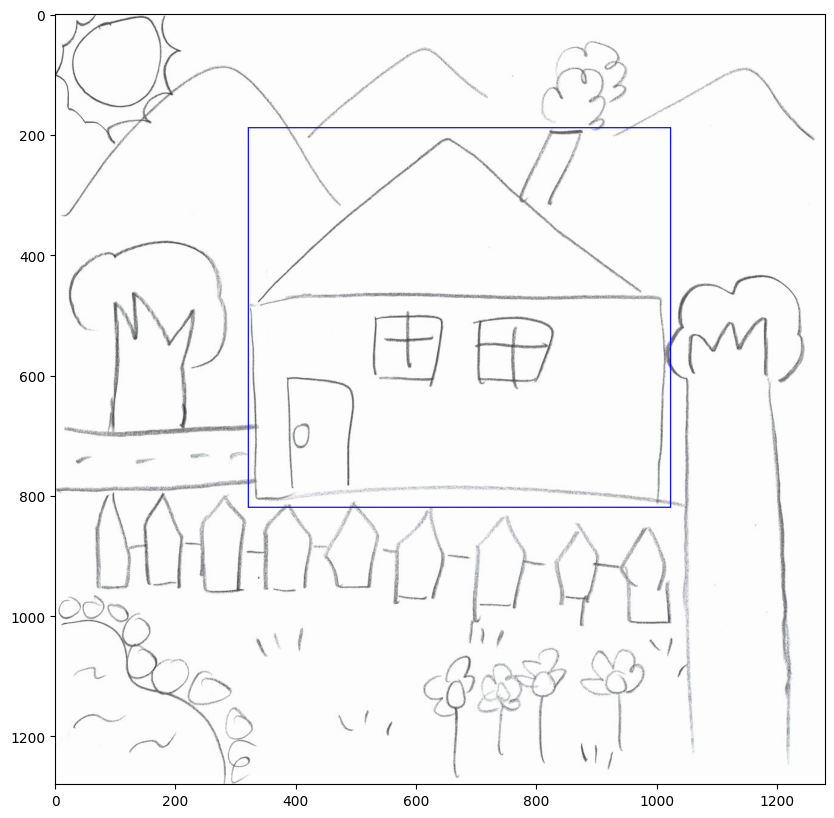

In [ ]:
draw_bounding_box(val_path, os.listdir(os.path.join(val_path, "images"))[0])

In [8]:
!python train.py --img 1280 --batch 16 --epochs 20 --data data/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name htp_yolov5s_results

2023-12-03 13:11:00.166479: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 13:11:00.166548: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 13:11:00.166589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=F